In [2]:
import os
import sqlite3
from dask.distributed import Client, LocalCluster

# set up cluster and workers
cluster = LocalCluster(n_workers=4,
threads_per_worker=1,
memory_limit='8GB') #my RAM size
client = Client(cluster)

# have a look at your workers client

import modin.pandas as pd
import seaborn as sns
import numpy as np
import re
#this sets up dask which is a multi processor library for data frames, 
#prob best to change the 64GB to 16GB and
#if this works you could try increasing the number of workers

In [3]:
def getlongestmatch(seq, umin = '2', umax = '', gapmin = '1', gapmax = '2', repeatmin = '2', repeatmax = ''):
  m = re.finditer(  '(([C]{' +umin+ ',' +umax+ '}[AGT]{' +gapmin+ ',' +gapmax+ '}){' +repeatmin+ ',' +repeatmax+ '})|(([G]{' +umin+ ',' +umax+ '}[ACT]{' +gapmin+ ',' +gapmax+ '}){' +repeatmin+ ',' +repeatmax+ '})',seq, flags = re.IGNORECASE)
  longest = ''
  lcount = 0
  span = ''
  for match in m:
    lcount += 1
    if len(match.group()) > len(longest):
      longest = match.group() #.group() tells you what exactly they found e.g. CCCCCC
      span = match.span() #tells you where exactly a match is found (startindx,endindex)
  m = re.finditer('(([C]{' +umin+ ',' +umax+ '}[AGT]{' +gapmin+ ',' +gapmax+ '}){' +repeatmin+ ',' +repeatmin+ '})|(([G]{' +umin+ ',' +umax+ '}[ACT]{' +gapmin+ ',' +gapmax+ '}){' +repeatmin+ ',' +repeatmin+ '})',seq, flags = re.IGNORECASE)
  count = 0
  for match in m:
    count += 1
  return longest, len(longest), span, lcount, count
#function to find the longest match of...GC?
#variable m stores function that iterates and finds through a genetic sequence string, from left to right I'm guessing C or G?
#m is short for match 
#print different things!!
#play around with regex and then plot different ones, some with Gs somewith Cs

In [4]:
con = sqlite3.connect('C:/Users/44795/Documents/release_db_v5.sqlite3')

In [5]:
# df = pd.read_sql_query('SELECT extra_gc.chromosome,extra_gc.start_idx,extra_gc.end_idx,extra_gc.sequence,extra_gc.state_name,extra_gc.gc,extra_gc.gc_min,extra_gc.gc_max,repeats.repeat_seq,repeats.hmm_state_id,repeats.has_gquad,repeats.has_repeats,repeats.n_repeats,repeats.align_seq,repeats.unit_seq from extra_gc left join repeats on (extra_gc.start_idx=repeats.start_idx and extra_gc.chromosome=repeats.chromosome) order by extra_gc.chromosome,extra_gc.start_idx ', con)
df = pd.read_sql('SELECT * from combined order by chromosome,start_idx ', con)
#this took a lot quicker this time-under a minute

To request implementation, send an email to feature_requests@modin.org.


In [5]:
df['longest'],df['length'],df['span'], df['longCount'], df['shortCount'] = zip(*df.sequence.apply(lambda x: getlongestmatch(x,'4','','1','5','2','')))
#longest runtime here-only have to execute once
#took like 5-10mins

In [11]:
df.iloc[0:100]
#displays rows from 300 to 400
#df.set_option('display.max_columns', None) #to display all rows and columns
#pd.set_option('display.max_rows') run them then comment them out 

,chromosome,start_idx,end_idx,sequence,state_name,gc,gc_min,gc_max,repchr,repstart,...,n_repeats,align_seq,unit_seq,ISTATE,region_length,longest,length,span,longCount,shortCount
0,chr1,10101,10800,CTAACCCAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAAC...,TUF,63.0,50.0,84.0,chr1,10101.0,...,32.0,ccaaccctaaccctaaccctaaccctaaccctaaccctaaccctaa...,CCAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAA...,TUFCORE,699,CCCCAACCCCAACCCCAACCCCAACCCCAACCCCAA,36,"(186, 222)",2,4
1,chr1,10801,11600,ACATGCTAGCGCGTCGGGGTGGAGGCGTGGCGCAGGCGCAGAGAGG...,DELETION,63.0,30.0,75.0,chr1,10801.0,...,3.0,catgctagcgcgtcggggtggaggcgtggcgcaggcgcagagaggc...,CATGCTAGCGCGTCGGGGTGGAGGCGTGGCGCAGGCGCAGAGAGGC...,CORE,799,GGGGGTTGGGGGGGC,15,"(211, 226)",2,2
2,chr1,11601,16900,CACCAGCAATGTCTAGGAATGCCTGTTTCTCCACAAAGTGTTTACT...,TUF,57.0,40.0,71.0,chr1,11601.0,...,0.0,NO_ALIGN,NO_UNIT,TUFCORE,5299,CCCCCAGCCCCCGGAGA,17,"(3275, 3292)",3,3
3,chr1,16901,17900,GAATGGTGCCAGGGGCAGAGGGGGCAATGCCGGGGCCCAGGTCGGC...,NORMAL,60.0,55.0,70.0,None,NaN,...,NaN,None,None,NORMAL,999,,0,,0,0
4,chr1,17901,19400,GCGGCCAGCAGACCTGCAGGGCCCGCTCGTCCAGGGGGCGGTGCTT...,TUF,60.0,53.0,75.0,None,NaN,...,NaN,None,None,TUF,1499,GGGGTATGGGGACTAC,16,"(350, 366)",1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,chr1,170701,176300,GAGTGGGGCAGAGCAGGGAGGAGTCCTGCACAGAGGAGAGGCAGGG...,NORMAL,48.0,21.0,67.0,None,NaN,...,NaN,None,None,NORMAL,5599,GGGGGTGGGGCAT,13,"(762, 775)",3,3
96,chr1,176301,176400,AAATGAAGATAATTACTGTGTTAAACACAGTTTCATAGAAAATAAA...,DELETION,26.0,26.0,26.0,None,NaN,...,NaN,None,None,DELETION,99,,0,,0,0
97,chr1,176401,180000,CACAGCTAAAGAAACAGGCTCAGAGAATGTTATTTGATTGGACCGT...,NORMAL,40.0,28.0,50.0,chr1,176599.0,...,0.0,NO_ALIGN,NO_UNIT,NORMAL,3599,,0,,0,0
98,chr1,180001,183400,AAACATGTCTTAATAGCCTTTACATTATGTAATAGTGTAATACAAA...,TUF,56.0,22.0,86.0,None,NaN,...,NaN,None,None,TUF,3399,GGGGGCGGGGGGGGGGGGGGGGGC,24,"(1576, 1600)",6,6


In [10]:
df.describe()
#this is very very useful - can separate the data to show each region and then plot - so select all just TUF, Normal etc

,start_idx,end_idx,gc,gc_min,gc_max,repstart,repend,hmm_state_id,has_gquad,has_repeats,n_repeats,region_length,length,longCount,shortCount
count,7.432900e+04,7.432900e+04,74329.000000,74329.000000,74329.000000,1.878100e+04,1.878100e+04,18781.000000,18781.000000,18781.000000,18781.000000,7.432900e+04,74329.000000,74329.000000,74329.000000
mean,6.746681e+07,6.750175e+07,46.502025,33.718750,59.837977,6.859924e+07,6.860131e+07,1.543848,0.112667,0.243597,2.728183,3.494699e+04,8.234390,7.279110,7.415141
std,5.950477e+07,5.951256e+07,12.918565,16.995969,16.160981,6.025902e+07,6.025893e+07,0.721389,0.316194,0.429264,9.912781,1.172664e+05,10.615572,24.021346,24.378829
min,1.000100e+04,1.010000e+04,0.000000,0.000000,0.000000,1.000100e+04,1.040000e+04,1.000000,0.000000,0.000000,0.000000,9.900000e+01,0.000000,0.000000,0.000000
25%,1.684900e+07,1.685590e+07,38.000000,22.000000,50.000000,1.716460e+07,1.716470e+07,1.000000,0.000000,0.000000,0.000000,2.990000e+02,0.000000,0.000000,0.000000
50%,5.404780e+07,5.411550e+07,45.000000,32.000000,62.000000,5.613984e+07,5.614084e+07,1.000000,0.000000,0.000000,0.000000,7.990000e+02,0.000000,0.000000,0.000000
75%,1.051301e+08,1.051603e+08,55.000000,44.000000,71.000000,1.103226e+08,1.103228e+08,2.000000,0.000000,0.000000,0.000000,4.899000e+03,17.000000,3.000000,3.000000
max,2.489407e+08,2.489464e+08,100.000000,100.000000,100.000000,2.487444e+08,2.487454e+08,3.000000,1.000000,1.000000,595.000000,2.406599e+06,247.000000,632.000000,645.000000


In [19]:
mydatanormal = df[df['ISTATE'] == 'NORMAL']
mydatanormal.describe()
print("There's no difference when you filter out the rows that have empty values") #mydatanormal.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)

,start_idx,end_idx,gc,gc_min,gc_max,repstart,repend,hmm_state_id,has_gquad,has_repeats,n_repeats,region_length,length,longCount,shortCount
count,3.195600e+04,3.195600e+04,31956.000000,31956.000000,31956.000000,1.112400e+04,1.112400e+04,11124.0,11124.000000,11124.000000,11124.000000,3.195600e+04,31956.000000,31956.000000,31956.000000
mean,6.981964e+07,6.989906e+07,44.252785,25.195550,65.136782,7.322194e+07,7.322294e+07,1.0,0.008270,0.076861,0.546386,7.942570e+04,12.030386,15.207066,15.422237
std,5.939002e+07,5.940509e+07,8.931012,14.686835,13.246151,5.902003e+07,5.902003e+07,0.0,0.090569,0.266382,2.415953,1.688208e+05,11.018369,34.773993,35.290605
min,1.030100e+04,1.230000e+04,0.000000,0.000000,0.000000,1.900800e+04,2.000800e+04,1.0,0.000000,0.000000,0.000000,9.900000e+01,0.000000,0.000000,0.000000
25%,1.896472e+07,1.912275e+07,38.000000,15.000000,57.000000,2.290372e+07,2.290472e+07,1.0,0.000000,0.000000,0.000000,7.990000e+02,0.000000,0.000000,0.000000
50%,5.897070e+07,5.912900e+07,43.000000,23.000000,66.000000,6.301162e+07,6.301262e+07,1.0,0.000000,0.000000,0.000000,4.499000e+03,15.000000,1.000000,1.000000
75%,1.070836e+08,1.073595e+08,50.000000,34.000000,75.000000,1.119004e+08,1.119014e+08,1.0,0.000000,0.000000,0.000000,7.682400e+04,21.000000,14.000000,14.000000
max,2.489379e+08,2.489382e+08,95.000000,95.000000,97.000000,2.487444e+08,2.487454e+08,1.0,1.000000,1.000000,36.000000,2.406599e+06,247.000000,632.000000,645.000000


In [8]:
df[df['ISTATE'] == 'TUFCORE'].describe()

,start_idx,end_idx,gc,gc_min,gc_max,repstart,repend,hmm_state_id,has_gquad,has_repeats,n_repeats,region_length,length,longCount,shortCount
count,5.100000e+03,5.100000e+03,5100.000000,5100.000000,5100.000000,5.100000e+03,5.100000e+03,5100.0,5100.000000,5100.000000,5100.000000,5100.000000,5100.000000,5100.000000,5100.000000
mean,6.288722e+07,6.289245e+07,52.366275,36.683529,65.313922,6.288722e+07,6.289245e+07,2.0,0.197059,0.478039,5.719412,5231.549020,10.954510,4.954902,5.083137
std,6.195009e+07,6.195012e+07,11.310603,14.063058,14.152355,6.195009e+07,6.195012e+07,0.0,0.397816,0.499566,16.046067,6893.204285,10.129011,9.267056,9.538300
min,1.000100e+04,1.040000e+04,0.000000,0.000000,1.000000,1.000100e+04,1.040000e+04,2.0,0.000000,0.000000,0.000000,99.000000,0.000000,0.000000,0.000000
25%,7.480975e+06,7.481874e+06,45.000000,27.000000,57.000000,7.480975e+06,7.481874e+06,2.0,0.000000,0.000000,0.000000,499.000000,0.000000,0.000000,0.000000
50%,4.431535e+07,4.432210e+07,54.000000,34.000000,69.000000,4.431535e+07,4.432210e+07,2.0,0.000000,0.000000,0.000000,2299.000000,13.000000,1.000000,1.000000
75%,1.102209e+08,1.102264e+08,60.000000,44.250000,75.000000,1.102209e+08,1.102264e+08,2.0,0.000000,1.000000,6.000000,7399.000000,18.000000,6.000000,6.000000
max,2.473736e+08,2.473744e+08,87.000000,87.000000,95.000000,2.473736e+08,2.473744e+08,2.0,1.000000,1.000000,595.000000,48499.000000,102.000000,78.000000,78.000000


In [28]:
df[df['ISTATE'] == 'CORE'].describe() #shorter way of doing it
#do it without missing values as well-but I removed iT-doesn't make a difference
#or you can just do df['CORE'].decribe()
#you can do df['CORE'].mean() #median() etc

,start_idx,end_idx,gc,gc_min,gc_max,repstart,repend,hmm_state_id,has_gquad,has_repeats,n_repeats,region_length,length,longCount,shortCount
count,2.557000e+03,2.557000e+03,2557.000000,2557.000000,2557.000000,2.557000e+03,2.557000e+03,2557.0,2557.000000,2557.000000,2557.000000,2557.000000,2557.000000,2557.000000,2557.000000
mean,5.988134e+07,5.988180e+07,59.086820,55.423543,62.979273,5.988134e+07,5.988180e+07,3.0,0.398514,0.501369,6.253813,462.511928,9.069613,2.271021,2.610872
std,6.025533e+07,6.025533e+07,15.781082,16.192266,16.302427,6.025533e+07,6.025533e+07,0.0,0.489688,0.500096,11.486201,673.139255,14.401324,4.542151,5.059189
min,1.040100e+04,1.050000e+04,0.000000,0.000000,0.000000,1.040100e+04,1.050000e+04,3.0,0.000000,0.000000,0.000000,99.000000,0.000000,0.000000,0.000000
25%,1.145690e+07,1.145720e+07,47.000000,41.000000,53.000000,1.145690e+07,1.145720e+07,3.0,0.000000,0.000000,0.000000,199.000000,0.000000,0.000000,0.000000
50%,3.649670e+07,3.649740e+07,63.000000,59.000000,67.000000,3.649670e+07,3.649740e+07,3.0,0.000000,1.000000,2.000000,299.000000,0.000000,0.000000,0.000000
75%,1.028019e+08,1.028021e+08,70.000000,67.000000,74.000000,1.028019e+08,1.028021e+08,3.0,1.000000,1.000000,8.000000,499.000000,15.000000,3.000000,3.000000
max,2.473735e+08,2.473736e+08,100.000000,100.000000,100.000000,2.473735e+08,2.473736e+08,3.0,1.000000,1.000000,135.000000,12699.000000,157.000000,83.000000,83.000000


In [9]:
df[df['ISTATE'] == 'DUPLICATION'].describe() #shorter way of doing it

,start_idx,end_idx,gc,gc_min,gc_max,repstart,repend,hmm_state_id,has_gquad,has_repeats,n_repeats,region_length,length,longCount,shortCount
count,9.876000e+03,9.876000e+03,9876.000000,9876.000000,9876.000000,0.0,0.0,0.0,0.0,0.0,0.0,9876.000000,9876.000000,9876.000000,9876.000000
mean,6.317714e+07,6.317770e+07,34.888011,30.602066,39.836371,NaN,NaN,NaN,NaN,NaN,NaN,555.692993,0.659072,0.071385,0.071993
std,5.468158e+07,5.468147e+07,9.919015,9.925709,12.219244,NaN,NaN,NaN,NaN,NaN,NaN,1316.411216,3.207256,0.497556,0.500715
min,1.460100e+04,1.580000e+04,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,99.000000,0.000000,0.000000,0.000000
25%,1.676672e+07,1.676682e+07,28.000000,24.000000,31.000000,NaN,NaN,NaN,NaN,NaN,NaN,99.000000,0.000000,0.000000,0.000000
50%,5.201600e+07,5.201635e+07,34.000000,29.000000,39.000000,NaN,NaN,NaN,NaN,NaN,NaN,299.000000,0.000000,0.000000,0.000000
75%,9.087565e+07,9.087575e+07,39.000000,36.000000,47.000000,NaN,NaN,NaN,NaN,NaN,NaN,499.000000,0.000000,0.000000,0.000000
max,2.489406e+08,2.489407e+08,81.000000,81.000000,93.000000,NaN,NaN,NaN,NaN,NaN,NaN,43399.000000,34.000000,20.000000,20.000000


In [216]:
df[df['ISTATE'] == 'DELETION'].describe() #shorter way of doing it

,start_idx,end_idx,gc,gc_min,gc_max,repstart,repend,hmm_state_id,has_gquad,has_repeats,n_repeats,region_length
count,6.526000e+03,6.526000e+03,6526.000000,6526.000000,6526.000000,0.0,0.0,0.0,0.0,0.0,0.0,6526.000000
mean,6.295401e+07,6.295437e+07,52.110634,48.723261,55.707937,NaN,NaN,NaN,NaN,NaN,NaN,360.998161
std,5.618987e+07,5.618988e+07,17.862927,18.663942,18.273358,NaN,NaN,NaN,NaN,NaN,NaN,1214.293894
min,1.000100e+04,1.010000e+04,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,99.000000
25%,1.864060e+07,1.864070e+07,41.000000,36.000000,45.000000,NaN,NaN,NaN,NaN,NaN,NaN,99.000000
50%,4.647305e+07,4.647330e+07,54.000000,51.000000,59.000000,NaN,NaN,NaN,NaN,NaN,NaN,199.000000
75%,9.031022e+07,9.031040e+07,64.000000,62.000000,67.000000,NaN,NaN,NaN,NaN,NaN,NaN,299.000000
max,2.487467e+08,2.487474e+08,97.000000,97.000000,100.000000,NaN,NaN,NaN,NaN,NaN,NaN,49099.000000


In [6]:
df[df['ISTATE'] == 'TUF'].describe()

,start_idx,end_idx,gc,gc_min,gc_max,repstart,repend,hmm_state_id,has_gquad,has_repeats,n_repeats,region_length
count,1.831400e+04,1.831400e+04,18314.000000,18314.000000,18314.000000,0.0,0.0,0.0,0.0,0.0,0.0,18314.000000
mean,6.961708e+07,6.961837e+07,51.300972,41.068800,60.886371,NaN,NaN,NaN,NaN,NaN,NaN,1296.286229
std,6.211793e+07,6.211793e+07,12.391741,13.879837,13.412155,NaN,NaN,NaN,NaN,NaN,NaN,2572.550147
min,1.000100e+04,1.030000e+04,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,99.000000
25%,1.662660e+07,1.662740e+07,43.000000,32.000000,54.000000,NaN,NaN,NaN,NaN,NaN,NaN,399.000000
50%,5.383565e+07,5.383600e+07,51.000000,39.000000,61.000000,NaN,NaN,NaN,NaN,NaN,NaN,599.000000
75%,1.134449e+08,1.134451e+08,59.000000,50.000000,69.000000,NaN,NaN,NaN,NaN,NaN,NaN,1199.000000
max,2.489407e+08,2.489464e+08,91.000000,91.000000,96.000000,NaN,NaN,NaN,NaN,NaN,NaN,74999.000000


Make sure to plot the section below to compare! Always better to look at averages
Comparing mean, std, median, max gc content and gcmin gc min look at max cos gc min in each region can't always be 0):

In [69]:
print("Table to show main findings of each state using the previous .describe() functions")
data = [["NORMAL",44.25, 8.93, 43, 97, 95, 38, 50], ["DUPLICATION",34.89, 9.91, 34, 93, 81, 28, 39], ["DELETION",52.11, 17.86, 54, 100, 97, 41, 64], ["CORE", 59.09, 15.78, 63, 100, 100, 47, 70], ["TUFCORE",52.37, 11.31, 54, 95, 87, 45, 60], ["TUF",51.3, 12.39, 51, 96, 91, 43, 59]]
pd.DataFrame(data, columns=["State","MeanOfGc", "Standard deviation", "Median","MaxGC","MinGc", "Lower Quartile (25%)", "Upper Quartile (75%)"])

Table to show main findings of each state using the previous .describe() functions


,State,MeanOfGc,Standard deviation,Median,MaxGC,MinGc,Lower Quartile (25%),Upper Quartile (75%)
0,NORMAL,44.25,8.93,43,97,95,38,50
1,DUPLICATION,34.89,9.91,34,93,81,28,39
2,DELETION,52.11,17.86,54,100,97,41,64
3,CORE,59.09,15.78,63,100,100,47,70
4,TUFCORE,52.37,11.31,54,95,87,45,60
5,TUF,51.30,12.39,51,96,91,43,59


In [46]:
mydata = pd.DataFrame({'Normal':[97, 95, 38, 50, 43],'Duplication':[93, 81, 28, 39, 34],'Deletion':[100, 97, 41, 64, 54],'Core':[100, 100, 47, 70, 63],'Tufcore':[95, 87, 45, 60, 54],'TUF':[96, 91, 43, 59,51]})
mydata.index = ['MaxGc','MinGc','LowerQ','UpperQ','Median']
mydata

,Normal,Duplication,Deletion,Core,Tufcore,TUF
MaxGc,97,93,100,100,95,96
MinGc,95,81,97,100,87,91
LowerQ,38,28,41,47,45,43
UpperQ,50,39,64,70,60,59
Median,43,34,54,63,54,51


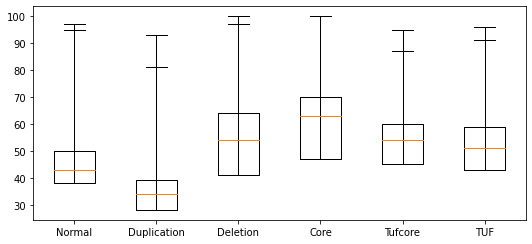

In [47]:
'''THIS PLOTS MAX, MIN, LOWER, UPPER AND MEDIAN'''
mydata.index = ['max','min','q1','q3', 'med']
labels = list(mydata.columns)

# create dictionaries for each column as items of a list
bxp_stats = mydata.apply(lambda x: {'med':x.med, 'q1':x.q1, 'q3':x.q3, 'whislo':x['min'], 'whishi':x['max']}, axis=0).tolist()

# add the column names as labels to each dictionary entry
for index, item in enumerate(bxp_stats):
    item.update({'label':labels[index]})

_, ax = plt.subplots()
ax.bxp(bxp_stats, showfliers=False);
plt.show()

#going to first try to add std to box plot, and if that dont work then do it with curves

In [15]:
mydatas = pd.DataFrame({'Normal':[97, 95, 38, 50, 43], 'Core':[100, 100, 47, 70, 63]})
mydatas.index = ['MaxGc','MinGc','LowerQ','UpperQ','Median']
mydatas

,Normal,Core
MaxGc,97,100
MinGc,95,100
LowerQ,38,47
UpperQ,50,70
Median,43,63


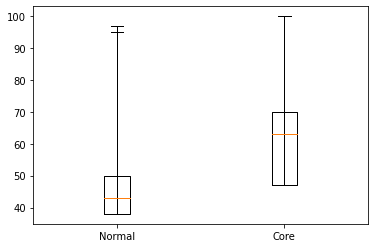

In [25]:
import matplotlib.pyplot as plt
'''THIS PLOTS MAX, MIN, LOWER, UPPER AND MEDIAN'''
mydatas.index = ['max','min','q1','q3', 'med']
labels = list(mydatas.columns)

# create dictionaries for each column as items of a list
bxp_stats = mydatas.apply(lambda x: {'med':x.med, 'q1':x.q1, 'q3':x.q3, 'whislo':x['min'], 'whishi':x['max']}, axis=0).squeeze().tolist()

# add the column names as labels to each dictionary entry
for index, item in enumerate(bxp_stats):
    item.update({'label':labels[index]})

_, ax = plt.subplots()
ax.bxp(bxp_stats, showfliers=False);
plt.show()

#going to first try to add std to box plot, and if that dont work then do it with curves

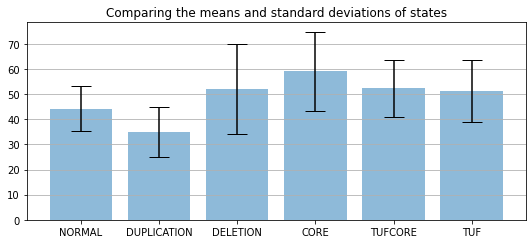

In [68]:
'''This plots means and standard deviations of states'''
import numpy as np
states = ['NORMAL','DUPLICATION','DELETION','CORE','TUFCORE','TUF']
x_pos = np.arange(len(states))
means= [44.25,34.89,52.11,59.09,52.37,51.30]
stds = [8.93,9.91,17.86,15.78,11.31,12.39]

# Build the plot
fig, ax = plt.subplots()
ax.bar(x_pos, means, yerr=stds, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_xticks(x_pos)
ax.set_xticklabels(states)
ax.set_title('Comparing the means and standard deviations of states GC content')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
plt.show()

# Typically for continuous data but still try...

CORE had the highest density, followed by DELETION and had the narrower ranges of region lengths
CORE, DELETION and DUPLICATION are highly concentrated at similar region lengths
TUFCORE and TUF have widest distribution
NORMAL doesn't have a distribution?


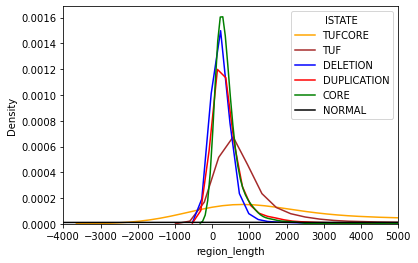

In [17]:
import matplotlib.pyplot as plt
sns.kdeplot(data=df[df["ISTATE"] == "TUFCORE"], x="region_length", color='orange')
sns.kdeplot(data=df[df["ISTATE"] == "TUF"], x="region_length", color='brown')
sns.kdeplot(data=df[df["ISTATE"] == "DELETION"], x="region_length", color='blue')
sns.kdeplot(data=df[df["ISTATE"] == "DUPLICATION"], x="region_length", color='red')
sns.kdeplot(data=df[df["ISTATE"] == "CORE"], x="region_length", color='green')
sns.kdeplot(data=df[df["ISTATE"] == "NORMAL"], x="region_length", color='black')
plt.legend(title='ISTATE', loc='upper right', labels=['TUFCORE', 'TUF','DELETION','DUPLICATION','CORE', 'NORMAL'])
plt.xlim(-4000, 5000)
#density plots are like histograms
#why is normal line flat?
print("CORE had the highest density, followed by DELETION and had the narrower ranges of region lengths")
print("CORE, DELETION and DUPLICATION are highly concentrated at similar region lengths")
print("TUFCORE and TUF have widest distribution")
print("NORMAL doesn't have a distribution?")
#what's causing this problem?

<AxesSubplot:xlabel='region_length', ylabel='Density'>

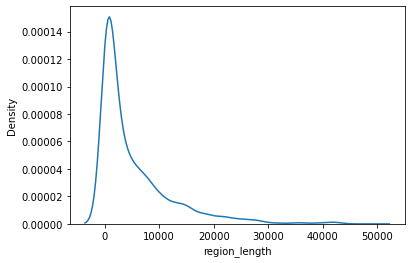

In [18]:
sns.kdeplot(data=df[df["ISTATE"] == "TUFCORE"], x="region_length")

# WHICH STATE HAS THE HIGHEST NUMBER OF REPEATS? 
## Number of repeats and number of ISTATE samples are not the same.
The highest number of repeats found is 595.
Normal has 36 repeats.
TUFCORE has 595 repeats.
CORE has 135 repeats.

# Categorical analysis and visualisation
Bar graph and pichart shows the size differences in sample regions of states

In [12]:
df['ISTATE'].value_counts()

NORMAL         31956
TUF            18314
DUPLICATION     9876
DELETION        6526
TUFCORE         5100
CORE            2557
Name: ISTATE, dtype: int64

<AxesSubplot:>

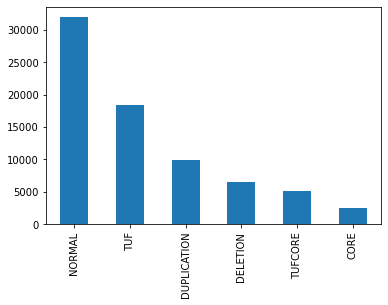

In [19]:
df['ISTATE'].value_counts().plot(kind='bar')
#normal is the most commonly found region in the sequence, followed by TUF

<AxesSubplot:ylabel='ISTATE'>

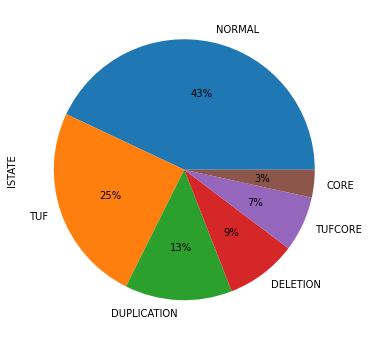

In [110]:
df['ISTATE'].value_counts().plot(kind='pie', autopct='%1.0f%%', figsize=(6,6))

In [48]:
df.info() 
#can help with showing you what you're plotting exactly

<class 'modin.pandas.dataframe.DataFrame'>
RangeIndex: 74329 entries, 0 to 74328
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  -------------  --------------  -----  
 0   chromosome     74329 non-null  object
 1   start_idx      74329 non-null  int64
 2   end_idx        74329 non-null  int64
 3   sequence       74329 non-null  object
 4   state_name     74329 non-null  object
 5   gc             74329 non-null  float64
 6   gc_min         74329 non-null  float64
 7   gc_max         74329 non-null  float64
 8   repchr         18781 non-null  object
 9   repstart       18781 non-null  float64
 10  repend         18781 non-null  float64
 11  repeat_seq     18781 non-null  object
 12  hmm_state_id   18781 non-null  float64
 13  has_gquad      18781 non-null  float64
 14  has_repeats    18781 non-null  float64
 15  n_repeats      18781 non-null  float64
 16  align_seq      18781 non-null  object
 17  unit_seq       18781 non-null  object
 18  ISTATE      

In [57]:
df['n_repeats'].median()

2.7281827378733827

# Correlation analysis - is there a relationship between the columns? 

In [164]:
corr = df.corr()
corr

,start_idx,end_idx,gc,gc_min,gc_max,repstart,repend,hmm_state_id,has_gquad,has_repeats,n_repeats,region_length
start_idx,1.000000,0.999998,-0.004324,-0.050154,0.065688,0.999999,0.999999,-0.089885,-0.012021,-0.013295,0.004483,0.065471
end_idx,0.999998,1.000000,-0.004592,-0.050986,0.066336,0.999999,0.999999,-0.090683,-0.012370,-0.013752,0.004237,0.067433
gc,-0.004324,-0.004592,1.000000,0.767082,0.690973,-0.030064,-0.030054,0.500541,0.453706,0.344396,0.187692,-0.136528
gc_min,-0.050154,-0.050986,0.767082,1.000000,0.127189,-0.076128,-0.076131,0.710284,0.386764,0.317856,0.179296,-0.425657
gc_max,0.065688,0.066336,0.690973,0.127189,1.000000,0.104047,0.104059,-0.206699,0.190102,0.045776,0.019233,0.333221
repstart,0.999999,0.999999,-0.030064,-0.076128,0.104047,1.000000,1.000000,-0.090296,-0.012207,-0.013540,0.004348,0.077842
repend,0.999999,0.999999,-0.030054,-0.076131,0.104059,1.000000,1.000000,-0.090286,-0.012186,-0.013514,0.004369,0.077836
hmm_state_id,-0.089885,-0.090683,0.500541,0.710284,-0.206699,-0.090296,-0.090286,1.000000,0.441726,0.432273,0.247852,-0.313795
has_gquad,-0.012021,-0.012370,0.453706,0.386764,0.190102,-0.012207,-0.012186,0.441726,1.000000,0.353292,0.183105,-0.135262
has_repeats,-0.013295,-0.013752,0.344396,0.317856,0.045776,-0.013540,-0.013514,0.432273,0.353292,1.000000,0.484987,-0.177135


The value 𝑟 > 0 indicates positive correlation.
The value 𝑟 < 0 indicates negative correlation.
The value r = 1 is the maximum possible value of 𝑟. It corresponds to a perfect positive linear relationship between variables.
The value r = −1 is the minimum possible value of 𝑟. It corresponds to a perfect negative linear relationship between variables.
The value r ≈ 0, or when 𝑟 is around zero, means that the correlation between variables is weak.

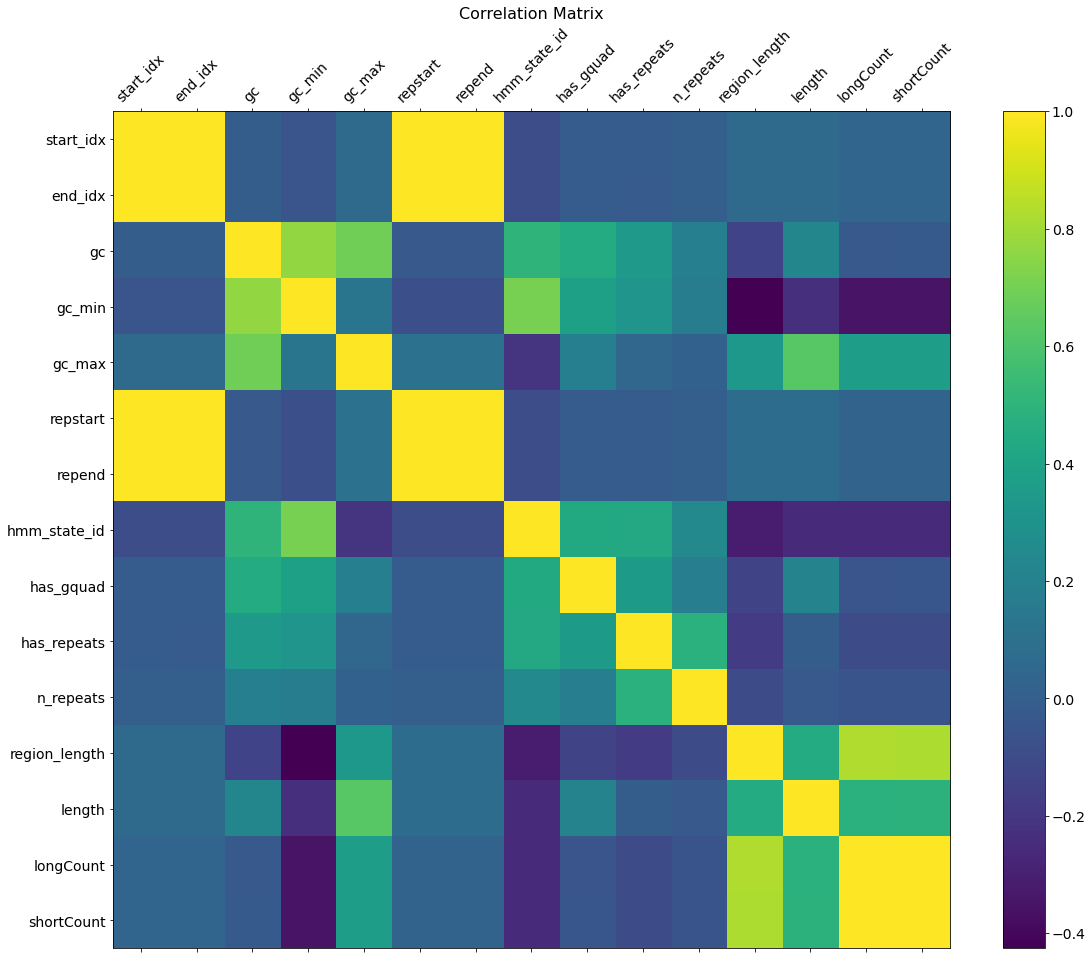

In [75]:
f = plt.figure(figsize=(19, 15))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);
#This doesn't really you much or make sense to be honest
#Not sure if this is relevant? Thought about correlation between hmm_state_id amd gc_min, length has no correlation with gc, 
#has_gquad has some sort of correlation with gc

# To do next
Make a code that looks for patterns within the patterns (e.g. do all normal longest repeats share a minimum sequence in column?)
Do i still take them into consideration even if some of the values are missing?
Summaries on different istates-average, size range of them, size differences, numbers, how many have repeats, stats on pattern matching, compare the patterns
Are any patterns unique to ISTATEs? E.g. Core vs Normal?
Do other databases overlap (later on-possible)

In [25]:
'''NORMAL ISTATE'''
#mydatanormal = df[df['ISTATE'] == 'NORMAL']
#mydatanormal.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)
#mydatanormal.sort_values(by='length', ascending=False)
#mydatanormal.iloc[0:100]
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows')# run them then comment them out 

'NORMAL ISTATE'

In [ ]:
mydatanormal = df[df['ISTATE'] == 'NORMAL']
#mydatanormal.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)
mydatanormal.sort_values(by='length', ascending=True)

In [87]:
normal = df[df['ISTATE'] == 'NORMAL']
normal = normal[['chromosome','n_repeats','ISTATE','hmm_state_id','has_gquad','longest','length','longCount','shortCount']]
normal = normal[(df['has_gquad'] == 1)]
normal
#hmm_state_id for normal is 1, for TUF it's 2, for Deletion it's 3 etc
#normal.sort_values(by='longCount', ascending=False)
#chromosome	n_repeats	ISTATE	hmm_state_id	has_gquad	longest	                length	longCount	shortCount
#51645	chr4	0.0 	NORMAL	1.0	0.0	CCCCTCCCCTCCCCTCCCCTCCCCTCCCCTCCCCTCCCCTCCCCTC...	70	74	81

,chromosome,n_repeats,ISTATE,hmm_state_id,has_gquad,longest,length,longCount,shortCount
148,chr1,0.0,NORMAL,1.0,1.0,CCCCTTTCCCCAA,13,6,6
765,chr1,0.0,NORMAL,1.0,1.0,GGGGTGGGGGGCCCAGGGGTTCCC,24,31,31
1546,chr1,0.0,NORMAL,1.0,1.0,CCCCCATCCCCATTCCCCCCCATT,24,39,39
1662,chr1,0.0,NORMAL,1.0,1.0,GGGGTGGGGGTTGGGGAGGGGCCTTT,26,3,4
3710,chr1,0.0,NORMAL,1.0,1.0,GGGGATGGGGATA,13,2,2
...,...,...,...,...,...,...,...,...,...
72605,chr9,0.0,NORMAL,1.0,1.0,GGGGCCACCGGGGGCCC,17,5,5
72609,chr9,0.0,NORMAL,1.0,1.0,CCCCAAGCCCCCACCCCCA,19,9,9
72621,chr9,0.0,NORMAL,1.0,1.0,GGGGCCACCGGGGGCCC,17,6,6
73614,chr9,0.0,NORMAL,1.0,1.0,CCCCAGCCCCAGCCCCGG,18,26,26


In [107]:
print(normal.max())
#They are not corresponding to the same row! Just maximum of each column.

start_idx        248937900.0
end_idx          248938199.0
gc                      95.0
gc_min                  95.0
gc_max                  97.0
repstart         248744354.0
repend           248745354.0
hmm_state_id             1.0
has_gquad                1.0
has_repeats              1.0
n_repeats               36.0
region_length      2406599.0
length                 247.0
longCount              632.0
shortCount             645.0
dtype: float64


In [7]:
normalwithoutgquad = df[df['ISTATE'] == 'NORMAL']
print(normalwithoutgquad.max()) #it's the same-no difference!

start_idx        248937900.0
end_idx          248938199.0
gc                      95.0
gc_min                  95.0
gc_max                  97.0
repstart         248744354.0
repend           248745354.0
hmm_state_id             1.0
has_gquad                1.0
has_repeats              1.0
n_repeats               36.0
region_length      2406599.0
dtype: float64


In [60]:
normal = df[df['ISTATE'] == 'NORMAL']
print(df[df['length'] == df['length'].max()])

      chromosome  start_idx   end_idx  \
35397       chr2   32916200  32916599   

                                                sequence  length        span  \
35397  GCGGGCGGGGCTGCGGGGGGGCGTGGGTAGGGGGGGGGGGTGGGGG...     247  (151, 398)   

[1 rows x 25 columns]


In [6]:
df[df['start_idx'] == 32916200]

,chromosome,start_idx,end_idx,sequence,state_name,gc,gc_min,gc_max,repchr,repstart,repend,repeat_seq,hmm_state_id,has_gquad,has_repeats,n_repeats,align_seq,unit_seq,ISTATE,region_length
35397,chr2,32916200,32916599,GCGGGCGGGGCTGCGGGGGGGCGTGGGTAGGGGGGGGGGGTGGGGG...,NORMAL,95.0,95.0,97.0,None,NaN,NaN,None,NaN,NaN,NaN,NaN,None,None,NORMAL,399


In [109]:
print(normal.min())

start_idx        10301.0
end_idx          12300.0
gc                   0.0
gc_min               0.0
gc_max               0.0
repstart         19008.0
repend           20008.0
hmm_state_id         1.0
has_gquad            0.0
has_repeats          0.0
n_repeats            0.0
region_length       99.0
length               0.0
longCount            0.0
shortCount           0.0
dtype: float64


In [108]:
print(normal[normal['length'] == normal['length'].min()])

      chromosome  start_idx    end_idx  \
3           chr1      16901      17900   
7           chr1      22201      23700   
9           chr1      23801      26900   
11          chr1      27101      29400   
17          chr1      56001      56600   
...          ...        ...        ...   
74310       chr9  138235300  138235999   
74314       chr9  138279200  138279899   
74319       chr9  138283900  138285599   
74322       chr9  138286000  138286099   
74324       chr9  138286200  138294099   

                                                sequence  length span  \
3      GAATGGTGCCAGGGGCAGAGGGGGCAATGCCGGGGCCCAGGTCGGC...       0        
7      CTTTCCTGCTGGACCTGACCCTGTGTCATGTCACCTTGCTACCACG...       0        
9      GAAGCTGCAGCCCTCCAGCTCGCCTCCCTCAATGGCCACTCCGTGC...       0        
11     AAAAGAAACAGCTTGAACAAAAAGTGTGTAGGGGAACCGCAAGCGG...       0        
17     GGGGTGAAATCCACTAATGAATTCCTTTTGCAGCTTAAGCCAATTC...       0        
...                                                  ... 

0.0    11032
1.0       92
Name: has_gquad, dtype: int64

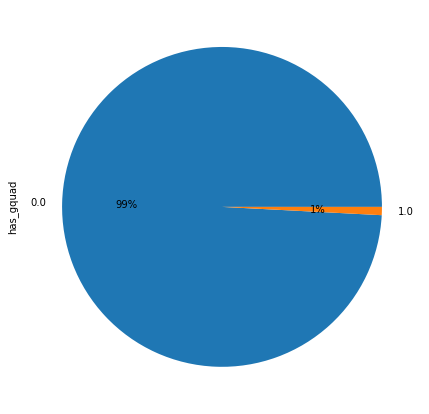

In [77]:
#which state has the highest gquad?
#which state has the highest gc content?
normal = df[df['ISTATE'] == 'NORMAL']
normal['has_gquad'].value_counts(dropna=True).plot(kind='pie', autopct='%1.0f%%', figsize=(6,6))
normal['has_gquad'].value_counts(dropna=True)

0.0    4095
1.0    1005
Name: has_gquad, dtype: int64

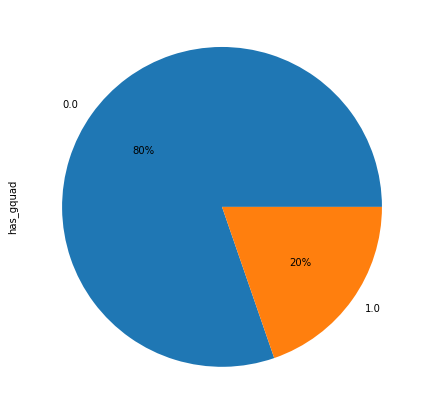

In [79]:
tufcore = df[df['ISTATE'] == 'TUFCORE']
tufcore['has_gquad'].value_counts(dropna=True).plot(kind='pie', autopct='%1.0f%%', figsize=(6,6))
tufcore['has_gquad'].value_counts(dropna=True)

0.0    1538
1.0    1019
Name: has_gquad, dtype: int64

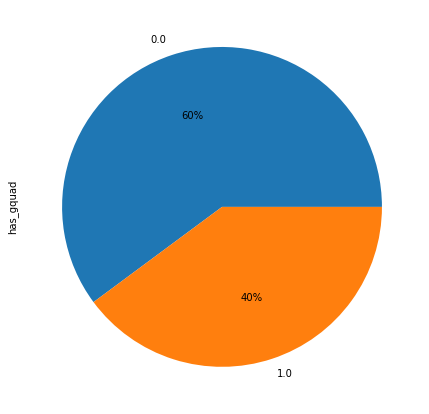

In [80]:
core = df[df['ISTATE'] == 'CORE']
core['has_gquad'].value_counts(dropna=True).plot(kind='pie', autopct='%1.0f%%', figsize=(6,6))
core['has_gquad'].value_counts(dropna=True)

# TUF, Deletion, Duplication have no Gquads!

Wasn't able to create piecharts for other states because they dont have any, but so far COREs seem to have the highest gquads present.

# Now to look for patterns

In [5]:
#use ur regex code to find any patterns in normal  for example
#kmersize for dictionary
#play around with the codes
#remember lambda to put it in and start and end print
#t(len)
#think about your observations-what do they actually tell?
#remember to take out nan for picharts
'''def gcminmax(tseq,win):
    tseq = tseq.lower()
    acgt = True
    if ((tseq.count('a') + tseq.count('c') + tseq.count('g') + tseq.count('t')) != len(tseq)):
        acgt = False
    start = 0
    end = win
    gcs = []
    while (end <= len(tseq)):
        tar = tseq[start:end]
        gcs = gcs + [round((tar.count('g') + tar.count('c')) / len(tar),2)]
    start += 1
    end += 1
    return (min(gcs),max(gcs))'''

"def gcminmax(tseq,win):\n    tseq = tseq.lower()\n    acgt = True\n    if ((tseq.count('a') + tseq.count('c') + tseq.count('g') + tseq.count('t')) != len(tseq)):\n        acgt = False\n    start = 0\n    end = win\n    gcs = []\n    while (end <= len(tseq)):\n        tar = tseq[start:end]\n        gcs = gcs + [round((tar.count('g') + tar.count('c')) / len(tar),2)]\n    start += 1\n    end += 1\n    return (min(gcs),max(gcs))"

In [6]:
#to incorporate in the dataframe you make lambda function again

def kmers(tseq,kmer):
    tseq = tseq.lower()
    start = 0
    end = kmer
    gcs = {} #dictionary
    while (end <= len(tseq)):
        tar = tseq[start:end]
        if tar not in gcs:
            gcs[tar] = 0
        gcs[tar] += 1
        start += 1
        end += 1
    return (gcs)

In [7]:
def gcminmax(tseq,win):
  tseq = tseq.lower()
  acgt = True
  if ((tseq.count('a') + tseq.count('c') + tseq.count('g') + tseq.count('t')) != len(tseq)):
    acgt = False
  target = len(tseq)
  start = 0
  end = win
  gcs = []
  mingcs = 1
  maxgcs = 0
  while (end <= target):
    tar = tseq[start:end]
    new = (tar.count('g') + tar.count('c')) / len(tar)
    if new < mingcs:
      mingcs = new
    if new > maxgcs:
      maxgcs = new
    start += 1
    end += 1
  return (mingcs,maxgcs,acgt)

In [8]:
df['mingcs'],df['maxgcs'],df['acgt'] = zip(*df.sequence.apply(lambda x: gcminmax(x, 10)))
#df['kmers'] = zip(*df.sequence.apply(lambda x: kmers(x, 4)))
df

#then we can do .describe again or filter out on each section 
#and then we gonna find actual visible patterns and not just mingcs and maxgcs
#longest runtime here-only have to execute once
#took like 20-30 mins

,chromosome,start_idx,end_idx,sequence,state_name,gc,gc_min,gc_max,repchr,repstart,...,ISTATE,region_length,longest,length,span,longCount,shortCount,mingcs,maxgcs,acgt
0,chr1,10101,10800,CTAACCCAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAAC...,TUF,63.0,50.0,84.0,chr1,10101.0,...,TUFCORE,699,CCCCAACCCCAACCCCAACCCCAACCCCAACCCCAA,36,"(186, 222)",2,4,0.3,1.0,True
1,chr1,10801,11600,ACATGCTAGCGCGTCGGGGTGGAGGCGTGGCGCAGGCGCAGAGAGG...,DELETION,63.0,30.0,75.0,chr1,10801.0,...,CORE,799,GGGGGTTGGGGGGGC,15,"(211, 226)",2,2,0.0,1.0,True
2,chr1,11601,16900,CACCAGCAATGTCTAGGAATGCCTGTTTCTCCACAAAGTGTTTACT...,TUF,57.0,40.0,71.0,chr1,11601.0,...,TUFCORE,5299,CCCCCAGCCCCCGGAGA,17,"(3275, 3292)",3,3,0.0,1.0,True
3,chr1,16901,17900,GAATGGTGCCAGGGGCAGAGGGGGCAATGCCGGGGCCCAGGTCGGC...,NORMAL,60.0,55.0,70.0,None,NaN,...,NORMAL,999,,0,,0,0,0.2,1.0,True
4,chr1,17901,19400,GCGGCCAGCAGACCTGCAGGGCCCGCTCGTCCAGGGGGCGGTGCTT...,TUF,60.0,53.0,75.0,None,NaN,...,TUF,1499,GGGGTATGGGGACTAC,16,"(350, 366)",1,1,0.2,1.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74324,chr9,138286200,138294099,GTTCAGCCACACTGCTTTGGTGTCACAACTGCACATTGGTTTCACA...,NORMAL,34.0,14.0,56.0,chr9,138286563.0,...,NORMAL,7899,,0,,0,0,0.0,1.0,True
74325,chr9,138294100,138294499,GCTTGCGGTGAGCTGAGATCGCACCGCTGCACTCCAGCCTGGGCGA...,TUF,38.0,24.0,52.0,None,NaN,...,TUF,399,,0,,0,0,0.0,0.8,True
74326,chr9,138294500,138313799,GTATGGATAAGGCCCTGAGTCATCTTCCTGAGCTGAATGATAGTTA...,NORMAL,37.0,20.0,63.0,chr9,138297703.0,...,NORMAL,19299,CCCCATAGCCCCCATAATCCCCA,23,"(881, 904)",2,2,0.0,1.0,True
74327,chr9,138313800,138313999,GCTGAGATTGCGCCACTGCACTCCAGCCTGGGCGACAGAGCGAGAC...,DELETION,47.0,43.0,52.0,None,NaN,...,DELETION,199,,0,,0,0,0.0,0.8,True


In [45]:
#do .describe for each region again

In [26]:
#df['gcs'] = zip(*df.sequence.apply(lambda x: kmers(x, 2)))
#df
#doesnt work so ignore for now

In [7]:
gcminmax('GAATGGTGCCAGGGGCAGAGGGGGCAATGCCGGGG',10)

(0.5, 0.8, True)

In [52]:
kmers('GAATGGTGCCAGGGGCAGAGGGGGCAATGCCGGGGCCCAGGT',2)

{'ga': 2,
 'aa': 2,
 'at': 2,
 'tg': 3,
 'gg': 12,
 'gt': 2,
 'gc': 5,
 'cc': 4,
 'ca': 4,
 'ag': 4,
 'cg': 1}

# Changing region numbers to region sizes instead - wait til you hear back from Colin

In [44]:
#df.iloc[0:100]

normaldata = df[df['ISTATE'] == 'NORMAL']
Total = normaldata['region_length'].sum()
print("Normal region length total: ",Total)
dupdata = df[df['ISTATE'] == 'DUPLICATION']
Total = dupdata['region_length'].sum()
print("Duplication region length total: ",Total)
deldata = df[df['ISTATE'] == 'DELETION']
Total = deldata['region_length'].sum()
print("Deletion region length total: ", Total)
tufdata = df[df['ISTATE'] == 'TUF']
Total = tufdata['region_length'].sum()
print("Tuf region length total: ", Total)
tcdata = df[df['ISTATE'] == 'TUFCORE']
Total = tcdata['region_length'].sum()
print("TUFCORE region length total: ", Total)
coredata = df[df['ISTATE'] == 'CORE']
Total = coredata['region_length'].sum()
print("Core region length total: ", Total)
print("region length total is the same as total number of bases in each ISTATE")
#make sure to plot the average and quartiles, and plot in bargraph and piechart

Normal region length total:  2538127513
Duplication region length total:  5488024
Deletion region length total:  2355874
Tuf region length total:  23740186
TUFCORE region length total:  26680900
Core region length total:  1182643
region length total is the same as total number of bases in each ISTATE


In [24]:
deldata = df[df['ISTATE'] == 'DELETION']
Total = deldata['region_length'].mean()
print("Deletion region length mean: ", Total)

deldata = df[df['ISTATE'] == 'DELETION']
Total = deldata['region_length'].sum()
print("Deletion region length total: ", Total)
deldata.region_length.quantile([0.25,0.5,0.75])
#np.percentile(deldata.region_length, 50)  # median
#piechart would just show the totals but maybe like boxplots/bar graphsthe quartiles and averages?

Deletion region length mean:  360.99816120134847
Deletion region length total:  2355874


0.25     99.0
0.50    199.0
0.75    299.0
Name: region_length, dtype: float64

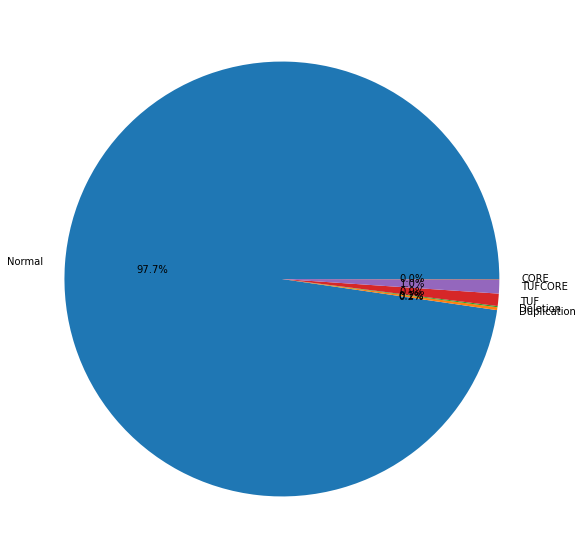

In [38]:
import matplotlib.pyplot as plt
import numpy as np

y = np.array([2538127513, 5488024, 2355874, 23740186, 26680900, 1182643])
mylabels = ["Normal", "Duplication", "Deletion", "TUF", "TUFCORE", "CORE"]
#myexplode = [0.5, 0, 0, 0.4, 0.2, 0.2]
plt.pie(y,labels=mylabels,autopct='%1.1f%%')#, explode = myexplode)
#plt.pie(y, labels = mylabels)
fig = plt.gcf()
fig.set_size_inches(10,10) # or (4,4) or (5,5) or whatever
plt.show() 

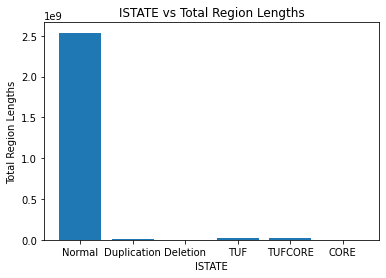

In [42]:
import matplotlib.pyplot as plt
   
ISTATES = ["Normal", "Duplication", "Deletion", "TUF", "TUFCORE", "CORE"]
Total_region_lengths = [2538127513, 5488024, 2355874, 23740186, 26680900, 1182643]

plt.bar(ISTATES, Total_region_lengths)
plt.title('ISTATE vs Total Region Lengths')
plt.xlabel('ISTATE')
plt.ylabel('Total Region Lengths')
plt.show()